In [1]:
# 10분 뒤 최대 전압 예측(PdM)

import pandas as pd
import os
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np


sel_features = ['hour','RACK_VOLTAGE','RACK_MIN_CELL_VOLTAGE','RACK_MIN_CELL_TEMPERATURE',
                'RACK_MAX_CELL_TEMPERATURE','RACK_CURRENT','minute','RACK_CELL_TEMPERATURE_GAP',
                'RACK_MAX_CELL_VOLTAGE','RACK_CELL_VOLTAGE_AVERAGE','RACK_CELL_VOLTAGE_GAP','day',
                'RACK_SOC','RACK_CELL_TEMPERATURE_AVERAGE'] # 10분 뒤 전압 예측 - 특징 선택.ipynb 로 선택한 특징들

label = "RACK_MAX_CELL_VOLTAGE" # y값, 최대 전압

def date_range(start, end):
    start = datetime.strptime(start, "%Y%m%d")
    end = datetime.strptime(end, "%Y%m%d")
    dates = [date.strftime("%Y%m%d") for date in pd.date_range(start, periods=(end-start).days+1)]
    return dates

train_dates = date_range("20211001", "20220430")

path = "./forecasting_data/"

train = pd.DataFrame()

for train_date in train_dates:
    try:
        ess_data = pd.read_feather(path + train_date + "/rack.feather")[sel_features]

        train = pd.concat([train, ess_data], axis=0)
    except:
        pass

trainX = train.iloc[:-600,:]
trainY = train.reset_index(drop=True).loc[600:,label].reset_index(drop=True)

In [2]:
from datetime import datetime
import numpy as np



def date_range(start, end):
    start = datetime.strptime(start, "%Y%m%d")
    end = datetime.strptime(end, "%Y%m%d")
    dates = [date.strftime("%Y%m%d") for date in pd.date_range(start, periods=(end-start).days+1)]
    return dates

valid_dates = date_range("20220501", "20220630")

path = "./forecasting_data/"

valid = pd.DataFrame()

for valid_date in valid_dates:
    try:
        ess_data = pd.read_feather(path + valid_date + "/rack.feather")[sel_features]
        valid = pd.concat([valid, ess_data], axis=0)
    except:
        pass

validX = valid.iloc[:-600,:]
validY = valid.reset_index(drop=True).loc[600:,label].reset_index(drop=True)

In [3]:
lightGBM_param = {"learning_rate"                    : 0.05, 
                  "num_leaves"                       : 255,
                  "colsample_bytree"                 : 0.8466655445017455,
                  "subsample"                        : 0.8363223383173761,
                  "verbosity"                        : -1,
                  "random_state"                     : 42,
                  "objective"                        : "regression",
                  "metric"                           : "l2",
                  "num_threads"                      : 10,
                  "min_sum_hessian_in_leaf"          : 0.3139754544772033,
                  "reg_alpha"                        : 1.3918976712256577e-07,
                  "reg_lambda"                       : 0.015222751757854997,
                  "n_estimators"                     : 1000,
                  "max_depth "                       : 10
                 } # LightGBM 하이퍼파라미터(10분 뒤 전압 예측 - 특징 선택.ipynb 참조)

XGBoost_param = {"max_depth" : 4,
                 "learning_rate": 0.10261711125039377,
                 "n_estimators": 2000,
                 "colsample_bytree": 0.8306482536182962,
                 "colsample_bylevel": 0.5200894204312736,
                 "colsample_bynode": 0.9125155627018552,
                 "reg_lambda": 0.29449215771684206,
                 "reg_alpha": 0.019867959415002325,
                 "subsample": 0.85,
                 "min_child_weight": 9,
                 "gamma" : 0.1010776765952064,
                 "tree_method" : 'gpu_hist', 
                 "gpu_id"=0
                } # XGBoost 하이퍼 파라미터(10분 뒤 전압 예측 - 특징 선택.ipynb 참조)

#trainX = train.iloc[:-600,:].drop(["TIMESTAMP","BANK_ID","RACK_ID"], axis=1)
#trainY = train.reset_index(drop=True).loc[600:,"RACK_MAX_CELL_VOLTAGE"].reset_index(drop=True)

trainX, trainY = trainX.apply(pd.to_numeric), trainY.apply(pd.to_numeric)
validX, validY = validX.apply(pd.to_numeric), validY.apply(pd.to_numeric)

In [5]:
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor(**lightGBM_param) # LGB 생성
lgb_model.fit(trainX, trainY) # 학습

[LightGBM] [Warning] max_depth is set=-1, max_depth= will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.3139754544772033, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.3139754544772033
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10


LGBMRegressor(colsample_bytree=0.8466655445017455, learning_rate=0.05,
              max_depth =10, metric='l2',
              min_sum_hessian_in_leaf=0.3139754544772033, n_estimators=1000,
              num_leaves=255, num_threads=10, objective='regression',
              random_state=42, reg_alpha=1.3918976712256577e-07,
              reg_lambda=0.015222751757854997, subsample=0.8363223383173761,
              verbosity=-1)

In [4]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(**XGBoost_param) # XGB 생성
xgb_model.fit(trainX,trainY) # 학습

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.5200894204312736,
             colsample_bynode=0.9125155627018552,
             colsample_bytree=0.8306482536182962, enable_categorical=False,
             gamma=0.1010776765952064, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.10261711125039377,
             max_delta_step=0, max_depth=4, min_child_weight=9, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.019867959415002325, reg_lambda=0.29449215771684206,
             scale_pos_weight=1, subsample=0.85, tree_method='approx',
             validate_parameters=1, verbosity=None)

In [6]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression().fit(trainX, trainY) # 학습 및 생성

In [7]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(task_type="GPU", devices='0:1').fit(trainX, trainY) # 학습 및 생성

Learning rate set to 0.144712
0:	learn: 0.1755281	total: 79.1ms	remaining: 1m 19s
1:	learn: 0.1507734	total: 156ms	remaining: 1m 17s
2:	learn: 0.1295967	total: 240ms	remaining: 1m 19s
3:	learn: 0.1114250	total: 319ms	remaining: 1m 19s
4:	learn: 0.0959048	total: 395ms	remaining: 1m 18s
5:	learn: 0.0826641	total: 471ms	remaining: 1m 18s
6:	learn: 0.0712916	total: 550ms	remaining: 1m 18s
7:	learn: 0.0616059	total: 628ms	remaining: 1m 17s
8:	learn: 0.0533576	total: 709ms	remaining: 1m 18s
9:	learn: 0.0463463	total: 784ms	remaining: 1m 17s
10:	learn: 0.0403890	total: 861ms	remaining: 1m 17s
11:	learn: 0.0353576	total: 936ms	remaining: 1m 17s
12:	learn: 0.0311233	total: 1.02s	remaining: 1m 17s
13:	learn: 0.0275810	total: 1.09s	remaining: 1m 16s
14:	learn: 0.0245983	total: 1.17s	remaining: 1m 16s
15:	learn: 0.0221369	total: 1.24s	remaining: 1m 16s
16:	learn: 0.0201307	total: 1.32s	remaining: 1m 16s
17:	learn: 0.0184690	total: 1.4s	remaining: 1m 16s
18:	learn: 0.0171300	total: 1.48s	remaining:

159:	learn: 0.0082407	total: 12.5s	remaining: 1m 5s
160:	learn: 0.0082351	total: 12.6s	remaining: 1m 5s
161:	learn: 0.0082293	total: 12.7s	remaining: 1m 5s
162:	learn: 0.0082257	total: 12.7s	remaining: 1m 5s
163:	learn: 0.0082213	total: 12.8s	remaining: 1m 5s
164:	learn: 0.0082179	total: 12.9s	remaining: 1m 5s
165:	learn: 0.0082104	total: 13s	remaining: 1m 5s
166:	learn: 0.0082035	total: 13s	remaining: 1m 5s
167:	learn: 0.0082001	total: 13.1s	remaining: 1m 4s
168:	learn: 0.0081969	total: 13.2s	remaining: 1m 4s
169:	learn: 0.0081925	total: 13.3s	remaining: 1m 4s
170:	learn: 0.0081876	total: 13.4s	remaining: 1m 4s
171:	learn: 0.0081837	total: 13.4s	remaining: 1m 4s
172:	learn: 0.0081734	total: 13.5s	remaining: 1m 4s
173:	learn: 0.0081646	total: 13.6s	remaining: 1m 4s
174:	learn: 0.0081583	total: 13.7s	remaining: 1m 4s
175:	learn: 0.0081549	total: 13.8s	remaining: 1m 4s
176:	learn: 0.0081482	total: 13.9s	remaining: 1m 4s
177:	learn: 0.0081436	total: 13.9s	remaining: 1m 4s
178:	learn: 0.00

318:	learn: 0.0072356	total: 25.3s	remaining: 54s
319:	learn: 0.0072335	total: 25.4s	remaining: 53.9s
320:	learn: 0.0072299	total: 25.4s	remaining: 53.8s
321:	learn: 0.0072260	total: 25.5s	remaining: 53.8s
322:	learn: 0.0072232	total: 25.6s	remaining: 53.7s
323:	learn: 0.0072185	total: 25.7s	remaining: 53.6s
324:	learn: 0.0072163	total: 25.8s	remaining: 53.5s
325:	learn: 0.0072125	total: 25.8s	remaining: 53.4s
326:	learn: 0.0072106	total: 25.9s	remaining: 53.3s
327:	learn: 0.0072077	total: 26s	remaining: 53.3s
328:	learn: 0.0072054	total: 26.1s	remaining: 53.2s
329:	learn: 0.0072035	total: 26.2s	remaining: 53.1s
330:	learn: 0.0072011	total: 26.2s	remaining: 53s
331:	learn: 0.0071987	total: 26.3s	remaining: 53s
332:	learn: 0.0071952	total: 26.4s	remaining: 52.9s
333:	learn: 0.0071930	total: 26.5s	remaining: 52.8s
334:	learn: 0.0071896	total: 26.5s	remaining: 52.7s
335:	learn: 0.0071846	total: 26.6s	remaining: 52.6s
336:	learn: 0.0071822	total: 26.7s	remaining: 52.5s
337:	learn: 0.007178

477:	learn: 0.0067488	total: 37.8s	remaining: 41.3s
478:	learn: 0.0067481	total: 37.9s	remaining: 41.2s
479:	learn: 0.0067420	total: 37.9s	remaining: 41.1s
480:	learn: 0.0067405	total: 38s	remaining: 41s
481:	learn: 0.0067381	total: 38.1s	remaining: 40.9s
482:	learn: 0.0067363	total: 38.2s	remaining: 40.9s
483:	learn: 0.0067289	total: 38.2s	remaining: 40.8s
484:	learn: 0.0067260	total: 38.3s	remaining: 40.7s
485:	learn: 0.0067251	total: 38.4s	remaining: 40.6s
486:	learn: 0.0067233	total: 38.5s	remaining: 40.5s
487:	learn: 0.0067214	total: 38.6s	remaining: 40.5s
488:	learn: 0.0067204	total: 38.6s	remaining: 40.4s
489:	learn: 0.0067194	total: 38.7s	remaining: 40.3s
490:	learn: 0.0067182	total: 38.8s	remaining: 40.2s
491:	learn: 0.0067150	total: 38.9s	remaining: 40.2s
492:	learn: 0.0067130	total: 39s	remaining: 40.1s
493:	learn: 0.0067115	total: 39.1s	remaining: 40s
494:	learn: 0.0067104	total: 39.1s	remaining: 39.9s
495:	learn: 0.0067093	total: 39.2s	remaining: 39.8s
496:	learn: 0.006708

636:	learn: 0.0063868	total: 50.5s	remaining: 28.8s
637:	learn: 0.0063854	total: 50.6s	remaining: 28.7s
638:	learn: 0.0063803	total: 50.6s	remaining: 28.6s
639:	learn: 0.0063778	total: 50.7s	remaining: 28.5s
640:	learn: 0.0063761	total: 50.8s	remaining: 28.5s
641:	learn: 0.0063753	total: 50.9s	remaining: 28.4s
642:	learn: 0.0063737	total: 51s	remaining: 28.3s
643:	learn: 0.0063729	total: 51s	remaining: 28.2s
644:	learn: 0.0063711	total: 51.1s	remaining: 28.1s
645:	learn: 0.0063702	total: 51.2s	remaining: 28.1s
646:	learn: 0.0063655	total: 51.3s	remaining: 28s
647:	learn: 0.0063641	total: 51.3s	remaining: 27.9s
648:	learn: 0.0063623	total: 51.4s	remaining: 27.8s
649:	learn: 0.0063613	total: 51.5s	remaining: 27.7s
650:	learn: 0.0063601	total: 51.6s	remaining: 27.7s
651:	learn: 0.0063566	total: 51.7s	remaining: 27.6s
652:	learn: 0.0063555	total: 51.8s	remaining: 27.5s
653:	learn: 0.0063539	total: 51.8s	remaining: 27.4s
654:	learn: 0.0063525	total: 51.9s	remaining: 27.3s
655:	learn: 0.0063

798:	learn: 0.0060973	total: 1m 3s	remaining: 16s
799:	learn: 0.0060962	total: 1m 3s	remaining: 15.9s
800:	learn: 0.0060942	total: 1m 3s	remaining: 15.8s
801:	learn: 0.0060935	total: 1m 3s	remaining: 15.7s
802:	learn: 0.0060927	total: 1m 3s	remaining: 15.6s
803:	learn: 0.0060922	total: 1m 3s	remaining: 15.6s
804:	learn: 0.0060914	total: 1m 3s	remaining: 15.5s
805:	learn: 0.0060881	total: 1m 3s	remaining: 15.4s
806:	learn: 0.0060872	total: 1m 4s	remaining: 15.3s
807:	learn: 0.0060865	total: 1m 4s	remaining: 15.2s
808:	learn: 0.0060856	total: 1m 4s	remaining: 15.2s
809:	learn: 0.0060849	total: 1m 4s	remaining: 15.1s
810:	learn: 0.0060831	total: 1m 4s	remaining: 15s
811:	learn: 0.0060825	total: 1m 4s	remaining: 14.9s
812:	learn: 0.0060810	total: 1m 4s	remaining: 14.8s
813:	learn: 0.0060797	total: 1m 4s	remaining: 14.8s
814:	learn: 0.0060785	total: 1m 4s	remaining: 14.7s
815:	learn: 0.0060762	total: 1m 4s	remaining: 14.6s
816:	learn: 0.0060757	total: 1m 4s	remaining: 14.5s
817:	learn: 0.00

957:	learn: 0.0058422	total: 1m 15s	remaining: 3.33s
958:	learn: 0.0058410	total: 1m 15s	remaining: 3.25s
959:	learn: 0.0058372	total: 1m 16s	remaining: 3.17s
960:	learn: 0.0058361	total: 1m 16s	remaining: 3.09s
961:	learn: 0.0058343	total: 1m 16s	remaining: 3.01s
962:	learn: 0.0058339	total: 1m 16s	remaining: 2.93s
963:	learn: 0.0058328	total: 1m 16s	remaining: 2.85s
964:	learn: 0.0058317	total: 1m 16s	remaining: 2.77s
965:	learn: 0.0058289	total: 1m 16s	remaining: 2.69s
966:	learn: 0.0058271	total: 1m 16s	remaining: 2.61s
967:	learn: 0.0058268	total: 1m 16s	remaining: 2.53s
968:	learn: 0.0058250	total: 1m 16s	remaining: 2.46s
969:	learn: 0.0058238	total: 1m 16s	remaining: 2.38s
970:	learn: 0.0058230	total: 1m 16s	remaining: 2.3s
971:	learn: 0.0058221	total: 1m 16s	remaining: 2.22s
972:	learn: 0.0058206	total: 1m 17s	remaining: 2.14s
973:	learn: 0.0058201	total: 1m 17s	remaining: 2.06s
974:	learn: 0.0058195	total: 1m 17s	remaining: 1.98s
975:	learn: 0.0058177	total: 1m 17s	remaining: 

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# MSE, MAE 결과 출력

lgb_pred = lgb_model.predict(validX[sel_features])
xgb_pred = xgb_model.predict(validX[sel_features])
linear_pred = linear_reg.predict(validX[sel_features])
cat_pred = cat_model.predict(validX[sel_features])

print(f"LightGBM loss(MSE) : {mean_squared_error(validY,lgb_pred)}")
print(f"XGBoost loss(MSE)  : {mean_squared_error(validY,xgb_pred)}")
print(f"Linear loss(MSE)  : {mean_squared_error(validY,linear_pred)}")
print(f"CatBoost loss(MSE)  : {mean_squared_error(validY,cat_pred)}")
print()

print(f"LightGBM loss(MAE) : {mean_absolute_error(validY,lgb_pred)}")
print(f"XGBoost loss(MAE)  : {mean_absolute_error(validY,xgb_pred)}")
print(f"Linear loss(MAE)  : {mean_absolute_error(validY,linear_pred)}")
print(f"CatBoost loss(MAE)  : {mean_absolute_error(validY,cat_pred)}")

LightGBM loss(MSE) : 0.00017900284174651813
XGBoost loss(MSE)  : 0.0004391554479221717
Linear loss(MSE)  : 0.00016836840314312824
CatBoost loss(MSE)  : 0.0002741259538875479
LightGBM loss(MAE) : 0.0050946239833772975
XGBoost loss(MAE)  : 0.006367748788137389
Linear loss(MAE)  : 0.005350151527762632
CatBoost loss(MAE)  : 0.0066257677701564155


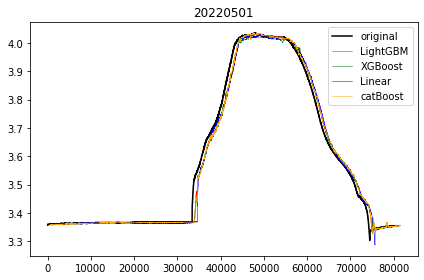

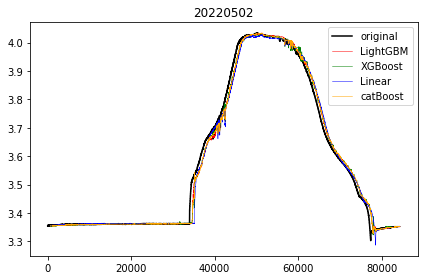

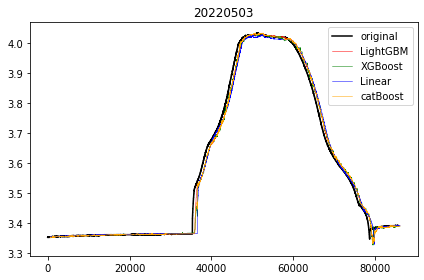

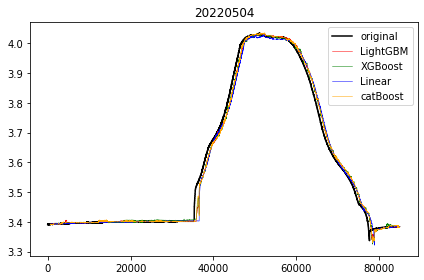

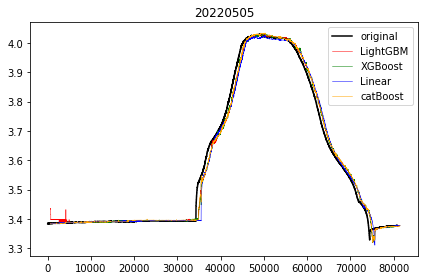

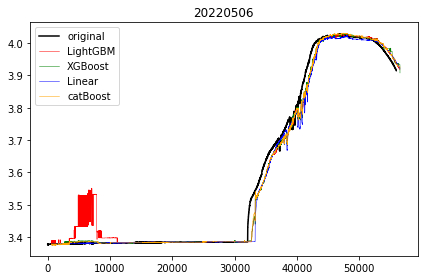

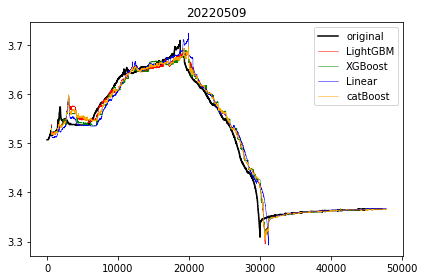

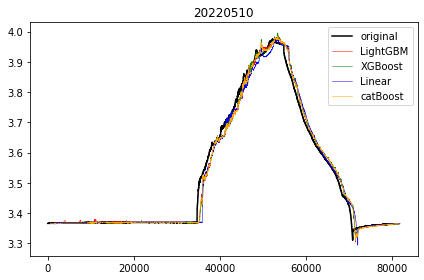

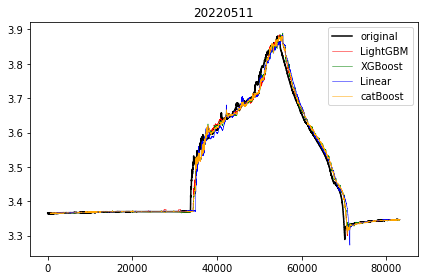

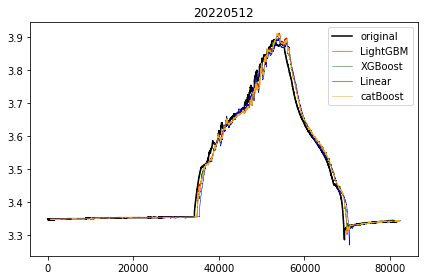

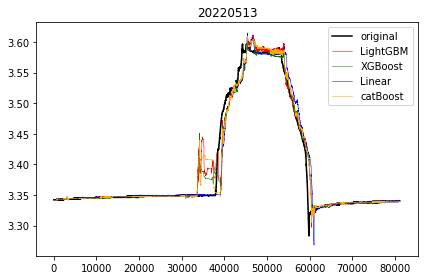

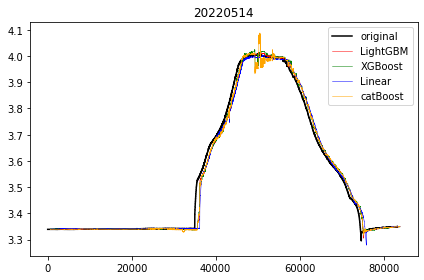

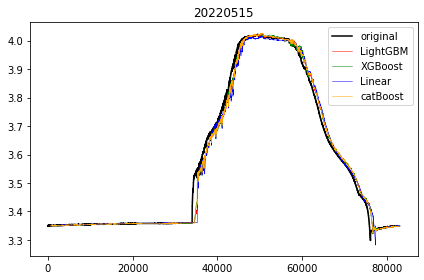

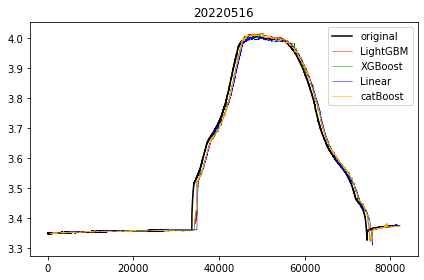

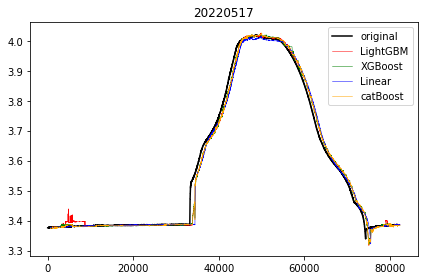

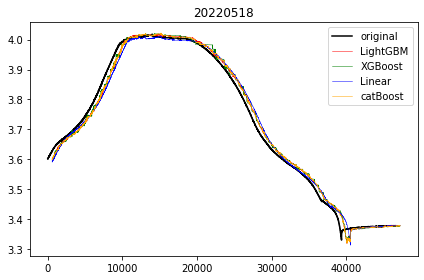

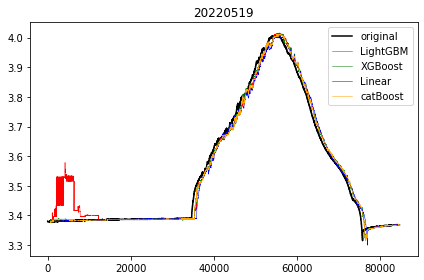

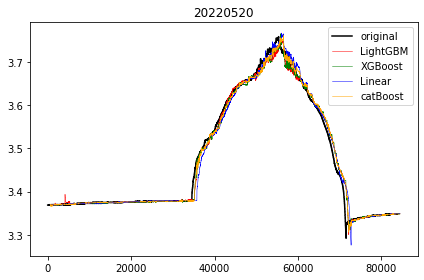

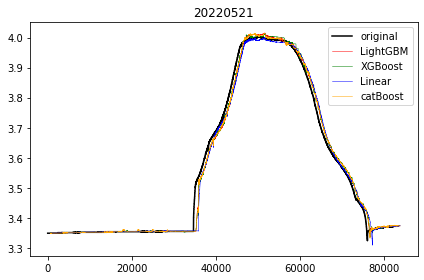

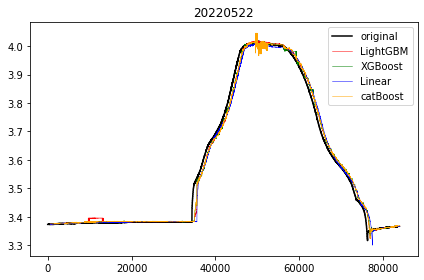

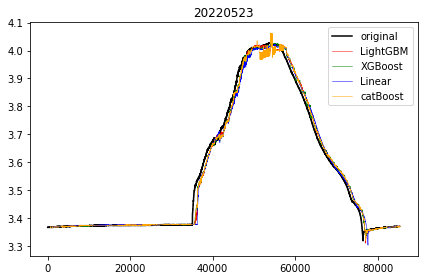

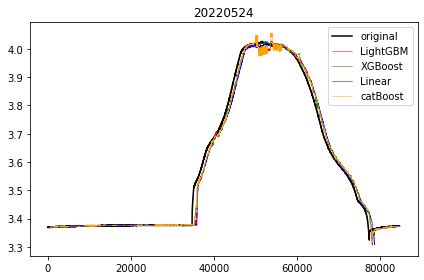

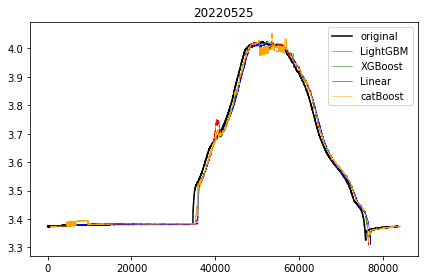

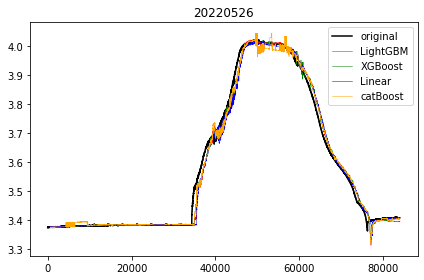

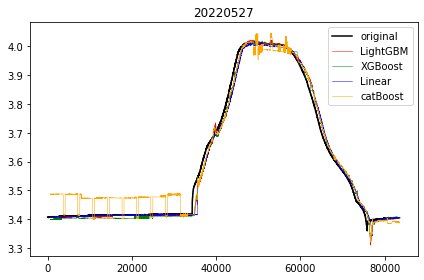

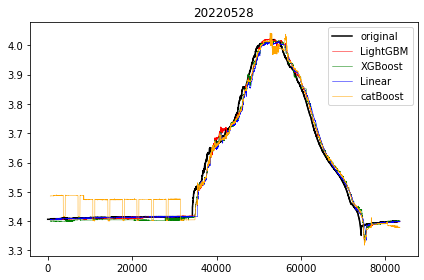

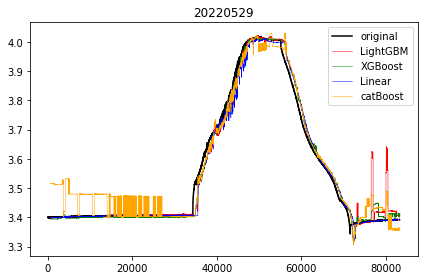

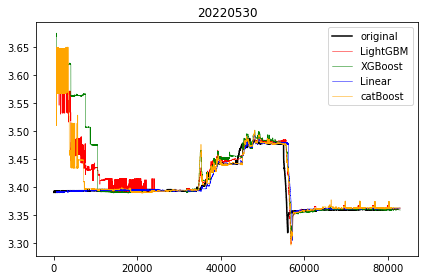

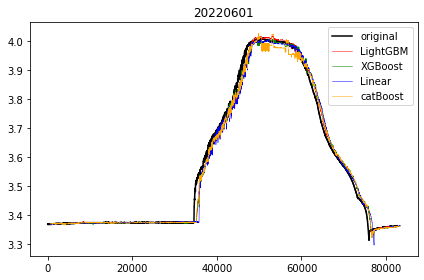

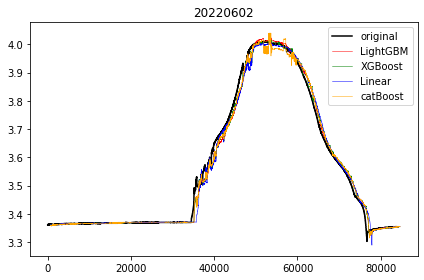

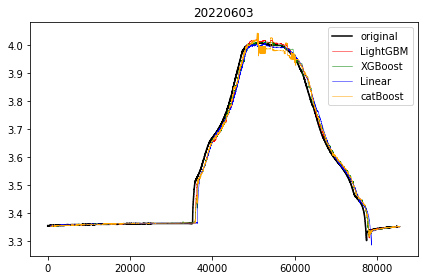

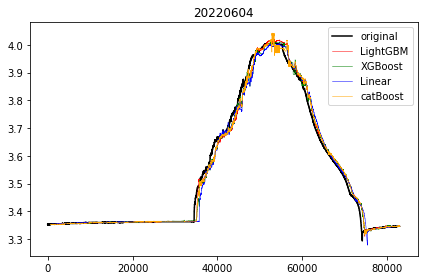

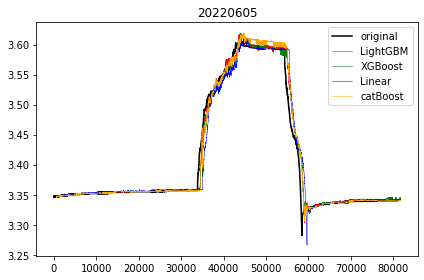

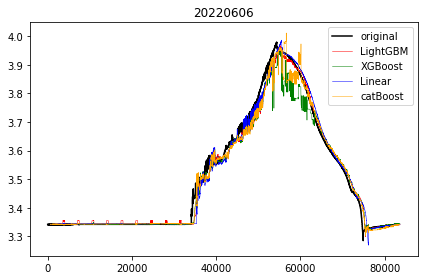

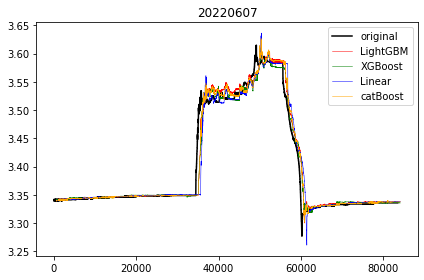

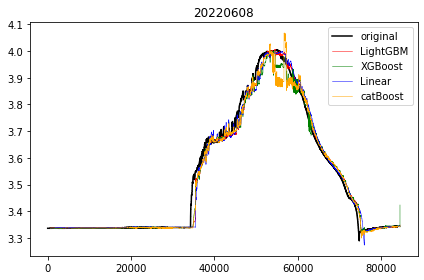

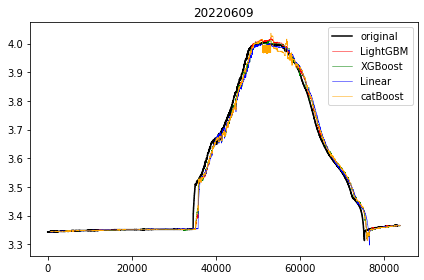

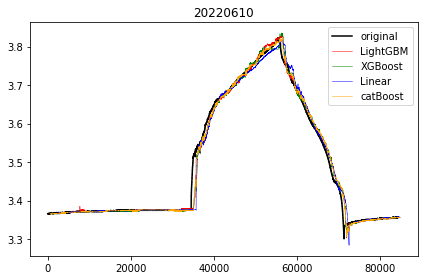

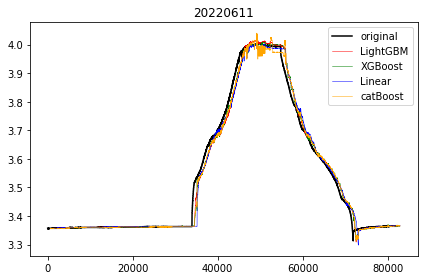

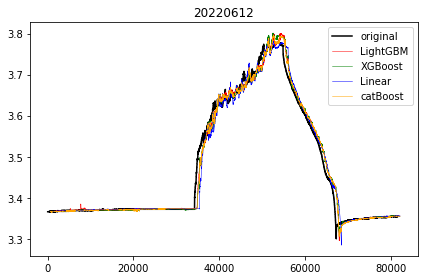

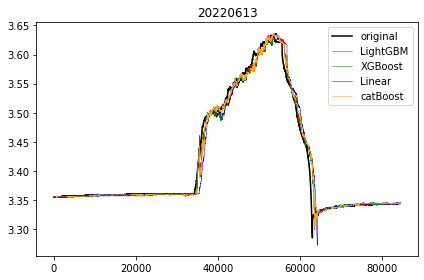

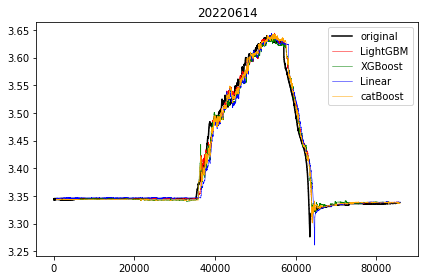

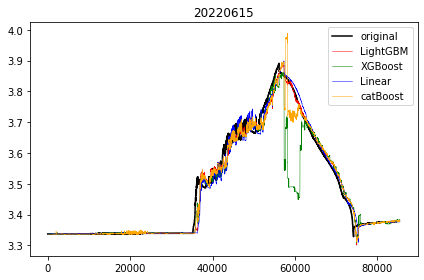

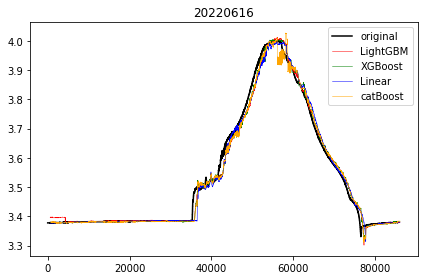

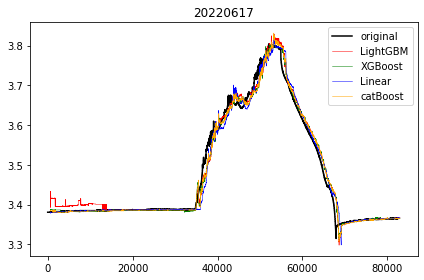

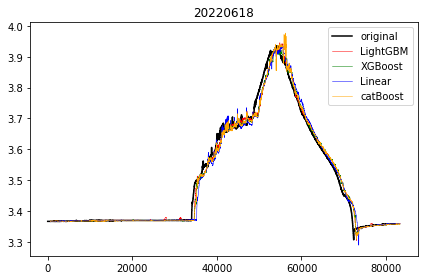

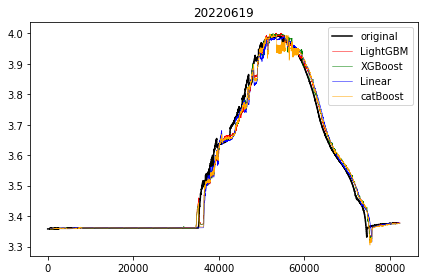

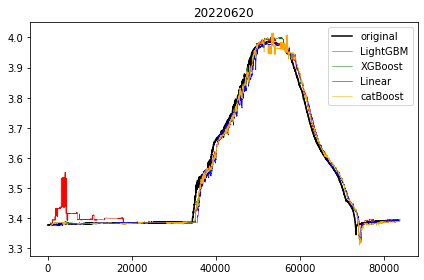

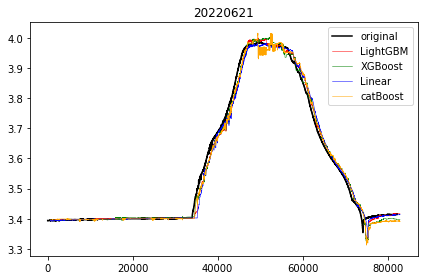

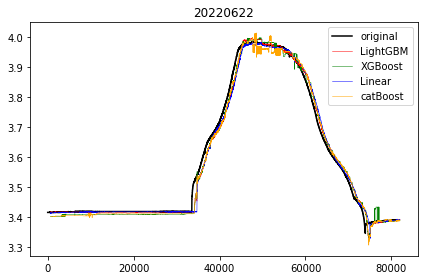

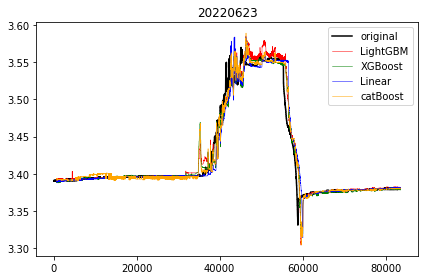

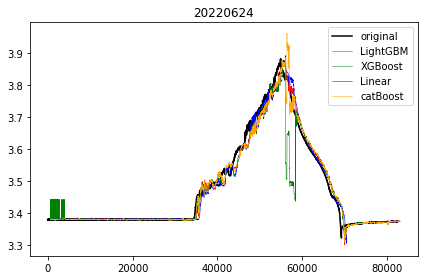

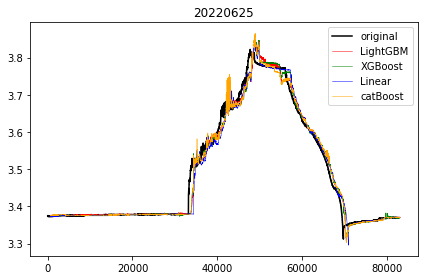

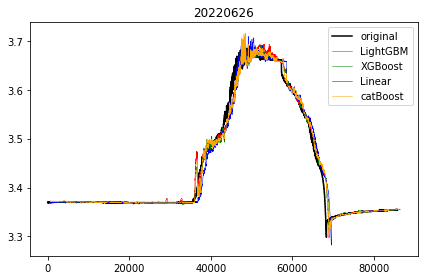

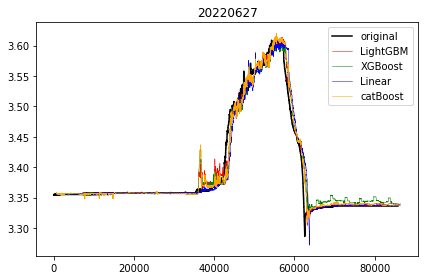

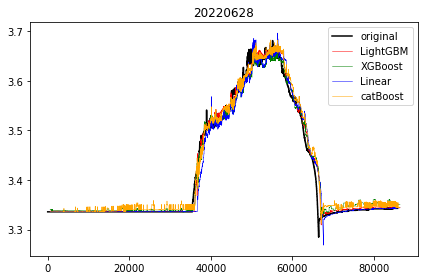

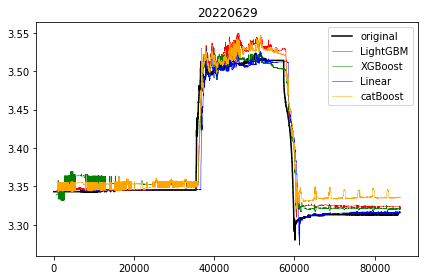

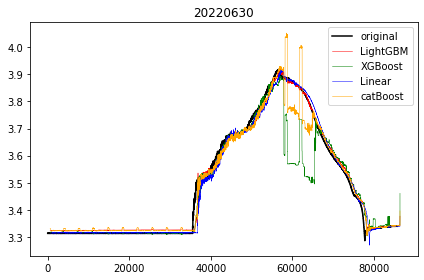

In [12]:
from datetime import datetime
import numpy as np
from sklearn.metrics import mean_squared_error


def date_range(start, end):
    start = datetime.strptime(start, "%Y%m%d")
    end = datetime.strptime(end, "%Y%m%d")
    dates = [date.strftime("%Y%m%d") for date in pd.date_range(start, periods=(end-start).days+1)]
    return dates

path = "./forecasting_data/"

save_f = "./figure/max_cell_voltages/"

for valid_date in valid_dates:
    try: # validation data 가져옴
        valid = pd.read_feather(path + valid_date + "/rack.feather")[sel_features]

        validX = valid.iloc[:-600,:]
        validY = valid.reset_index(drop=True).loc[600:,label].reset_index(drop=True)

        lgb_pred = lgb_model.predict(validX)
        xgb_pred = xgb_model.predict(validX)
        linear_pred = linear_reg.predict(validX)
        cat_pred = cat_model.predict(validX)
    except:
        continue
    '''
    plt.subplot(2,3,1)
    plt.hist(validY, range=(3.2,4.2), color = 'b', label = 'original')
    
    plt.subplot(2,3,2)
    plt.hist(lgb_pred, range=(3.2,4.2), color = 'orange', label = 'prediction(LightGBM)')
    
    plt.subplot(2,3,3)
    plt.hist(xgb_pred, range=(3.2,4.2), color = 'green', label = 'prediction(XGBoost)')
    
    plt.subplot(2,3,6)
    plt.plot(range(len(validY)),validY, color='black', label = 'original')
    
    
    ax0 = plt.subplot2grid((2, 3), (0, 0), rowspan=1, colspan=1)
    ax1 = plt.subplot2grid((2, 3), (0, 1), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((2, 3), (0, 2), rowspan=1, colspan=1)
    ax3 = plt.subplot2grid((2, 3), (1, 0), rowspan=1, colspan=3)

    ax0.hist(validY, range=(3.2,4.2), color = 'b', label = 'original')
    ax1.hist(lgb_pred, range=(3.2,4.2), color = 'orange', label = 'LightGBM')
    #ax2.hist(xgb_pred, range=(3.2,4.2), color = 'green', label = 'XGBoost')
    ax2.hist(linear_pred, range=(3.2,4.2), color = 'green', label = 'Linear')
    
    length = len(validY)
    ax3.plot(range(len(validY)),validY, color='black', label = 'original')
    ax3.plot(range(600,length+600), lgb_pred, color = 'orange', label = 'prediction')
    #ax3.plot(range(600,length+600), xgb_pred, color = 'green', label = 'prediction')
    ax3.plot(range(600,length+600), linear_pred, color = 'green', label = 'prediction')
    
    ax0.legend(loc='upper left')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')
    '''
    length = len(validY)
    
    plt.plot(range(len(validY)),validY, color='black', label = 'original')
    plt.plot(range(600,length+600), lgb_pred, color = 'r', linewidth = 0.5, label = 'LightGBM')
    plt.plot(range(600,length+600), xgb_pred, color = 'g', linewidth = 0.5, label = 'XGBoost')
    plt.plot(range(600,length+600), linear_pred, color = 'b', linewidth = 0.5, label = 'Linear')
    plt.plot(range(600,length+600), cat_pred, color = 'orange', linewidth = 0.5, label = 'catBoost')
    
    plt.legend()
    
    plt.title(valid_date)
    
    plt.tight_layout()
    plt.savefig(save_f+f"{valid_date}.jpg", dpi=600) # 그림 저장
    
    plt.show()

In [14]:
# 모델 저장

import joblib

joblib.dump(lgb_model, "./model/max_cell_voltage/lgb_model.pkl") 
joblib.dump(xgb_model, "./model/max_cell_voltage/xgb_model.pkl") 
joblib.dump(linear_reg, "./model/max_cell_voltage/linear_model.pkl") 
joblib.dump(cat_model, "./model/max_cell_voltage/cat_model.pkl") 

['./model/max_cell_voltage/cat_model.pkl']